## Beispiel eines Neuronalen Netzes zur Vorhersage von Kundenabwanderung
Genutzt wird in diesem Fall ein **LSTM**-Netz (Long-Short-Term-Memory)
, welches besonders gut für die Analyse von längeren Sequenzen (Texte, Kursverläufe etc.) geeignet ist.
In unserem Fall sind dies Bestellverläufe verschiedener Kunden. Ziel ist es, das Netz auf einen Teil der Kundenbestellungen zu trainieren, und mit dem Rest zu testen ob das System diese richtig als abgesprungen oder nicht abgesprungen klassifiziert.

#### Wie führt man den Code aus?
Im folgenden Dokument finden Sie Codefragmente (Zellen) und Text, der beschreibt was der Code macht. 
Die Code-Zellen müssen nacheinander von Ihnen ausgeführt werden.
* Klicken Sie in die Zelle, um diese auszuwählen
* Drücken Sie *Shift+Enter* um den gesamten Code der ausgewählten Zelle auszuführen. Dabei springt die Auswahl auf die nächste Zelle.
* Um zwischen den Zellen zu springen drücken Sie *Strg+Hoch/Runter*. 
Weiter Shortcuts unter Help.

Wenn Sie wenig Erfahrung mit Programmierung und Machine Learning haben wird der Code sicher schwer zu verstehen sein. Achten Sie auf die Beschreibungen und lassen Sie sich nicht Einschüchtern!
Sie werden ein paar Einladungen zur Interaktion mit dem Code finden!

## Imports und Funktionen

Die wichtigsten Bibliotheken:
* **Keras** - Hauptframework für Machine Learning. (Basiert auf Google's Tensorflow)
* **Numpy** - Unter anderem zur Durchführung von Vektorberechnungen.
* **Pandas** - Regelt den Import und die Formatierung von Daten.
* **Matplotlib** - Zur Erstellung von Diagrammen

In [1]:
import random as rn
from datetime import datetime

from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Masking, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
RANDOM_SEED = 40

rn.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

Funktion: *Inner-Join* auf zwei Datensätzen

In [3]:
def drop_missing_values_vise_versa(df1, df2, column_name):
    """Entferne die fehlenden Werte anhand einer Spalte
    
    Args:
        df1 (:obj:`pandas.DataFrame`): 1. DataFrame
        df2 (:obj:`pandas.DataFrame`): 2. DataFrame
        column_name (:obj:`str`): relevanter Spaltenname
    
    Returns:
        tuple of two :obj:`pandas.DataFrame`
    """
    
    assert column_name in df1.columns and column_name in df2.columns, 'Spaltenname muss in beiden DFs vorliegen.'

    drop_condition = df1[column_name].isin(df2[column_name]) == False
    df1 = df1.drop(df1[drop_condition].index)

    drop_condition = df2[column_name].isin(df1[column_name]) == False
    df2 = df2.drop(df2[drop_condition].index)

    return df1, df2

Funktion: welche fehlende Daten einer Zeitreihe auffüllt. Wenn kein Wert da ist tragen wir eine 0 ein.

In [4]:
def fill_dates(df, end_date):
    """Fülle die Zeitreihen bis zu einem gegebenen Datum auf
    
    Args:
        df (:obj:`pandas.DataFrame`): DataFrame mit Zeitreihen
        end_date (:obj:`datetime.datetime`)
    
    Returns:
        :obj:`pandas.DataFrame` aufgefüllter DataFrame
    """

    start_date = df['date'].iloc[0]
    if start_date > end_date or len(df) == 0:
        return df

    months_diff = ((end_date.year - start_date.year) * 12 + end_date.month - start_date.month)
    date_list = [start_date + relativedelta(months=x) for x in range(0, months_diff)]
    date_frame = pd.DataFrame(date_list)
    date_frame.columns = ['date']
    value = pd.merge(date_frame, df, how='left').fillna(0)
    value = value.drop(['date'], axis=1)

    return value

## Einlesen der Daten mithilfe von **Pandas**
* Es wird zwischen X und Y-Werten unterschieden.
* Die X-Werte sind in unserem Fall die Bestellverläufe.
* Der Y-Wert ist ein *boolean*-Wert, welcher besagt ob ein Kunde abgesprungen ist.

In [5]:
x_data = pd.read_csv("cleaned_orders.csv", header=0, index_col=0, sep=",", decimal=".", dtype={0:int})
x_data['date'] = pd.to_datetime(x_data.date, format='%Y-%m-%d')

x_data['date'].describe() # scope: monthly, 2015-02 until 2019-09

count                   20112
unique                     57
top       2019-02-01 00:00:00
freq                      458
first     2015-02-01 00:00:00
last      2019-10-01 00:00:00
Name: date, dtype: object

In [6]:
x_data = pd.read_csv("cleaned_orders.csv", header=0, index_col=0, sep=",", decimal=".", dtype={0:int})
x_data['date'] = pd.to_datetime(x_data.date, format='%Y-%m-%d') # scope: monthly, 2015-02 until 2019-09
x_data = x_data.drop("quantity", axis=1)
x_data = x_data[x_data.date < '2018-09-01'] # spätere Daten wurden zur Churn Bestimmung (y-Daten) benutzt


In [7]:
y_data = pd.read_csv("cleaned_y_data_friends.csv", header=0, index_col=0, sep=",", dtype={0:int,1:int})
y_data = y_data.sort_values('recipient').reset_index(drop=True)

In [8]:
x_data, y_data = drop_missing_values_vise_versa(x_data, y_data, 'recipient')

## Data-Exploration

Wieviele Kunden haben wir im Dataset?

In [9]:
x_data.nunique() # Anzahl der "unique" Werte pro Spalte (es gibt viele Spalten pro Rezipient)

recipient     352
date           43
sales        1357
dtype: int64

Wie ist der Umsatz auf die Kunden verteilt?

Text(0, 0.5, 'Summe Umsatz in Mio')

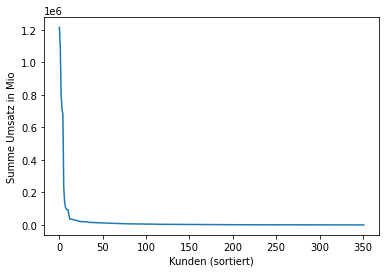

In [10]:
grouped = x_data.groupby('recipient', as_index=False)
recipients_total_sales = grouped.agg(np.sum)
recipients_total_sales.sort_values(by="sales", ascending=False, inplace=True)
recipients_total_sales.reset_index(inplace=True, drop=True)
plt.plot(recipients_total_sales["sales"])
plt.xlabel("Kunden (sortiert)")
plt.ylabel("Summe Umsatz in Mio")

Es sieht so aus als währen viele "leere" Kunden dabei. 
Schauen wir uns das genauer an. Eine log-Skala ist angebracht.

c:\users\robert\appdata\local\programs\python\python38\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'log Summe Umsatz')

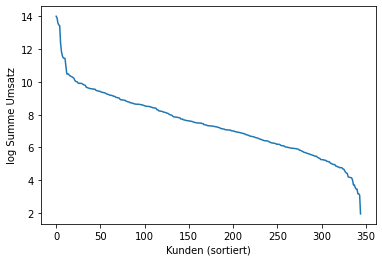

In [11]:
# recipients_total_sales[recipients_total_sales.sales == 0].count()
plt.plot(np.log(recipients_total_sales["sales"]))
plt.xlabel("Kunden (sortiert)")
plt.ylabel("log Summe Umsatz")

## Soziale Beziehungen

Wir haben für jeden Kunden die Anzahl von "Churnern" gezählt, die im Bekanntenkreis zu finden sind. Solche Daten könnte man aus einem sozialen Netzwerk extrahieren. Unsere Daten sind einfach generiert.

Eine mögliche Hypothese ist, dass Kunden, die eine erhöhte Anzahl an Churnern im Bekanntenkreis haben, selbst eine erhöhte Churn-Wahrscheinlichkeit aufweisen.
Wie könnte man durch einen Plot dieser Hypothese nachgehen?

In [12]:
y_data.head(3)

,recipient,churned,churner_friends
0,11675,0,1
1,12589,0,4
2,13593,1,4


**Hier sind Sie gefragt!**

Wofür stehen wohl die Gruppen A und B? Ersetzen Sie die den Text der Labels und führen Sie die Zelle erneut aus.

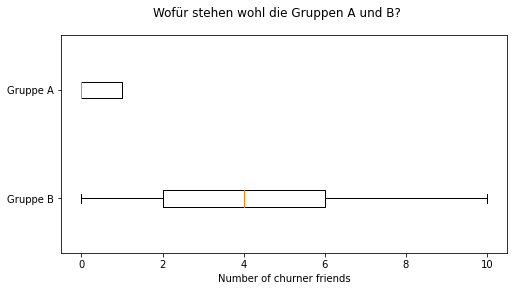

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(8,4)

labels=["Gruppe B", "Gruppe A"]

data = [y_data["churner_friends"], y_data["churned"]]

ax.boxplot(data, labels=labels, vert=False)
ax.set_xlabel("Number of churner friends")
fig.suptitle("Wofür stehen wohl die Gruppen A und B?")
plt.show()

Hier teilen wir die Tabelle auf, weil wir als y-Daten eigentlich nur die Kundennummer und den Abwanderungstatus wollen.

In [14]:
friends = y_data.iloc[:,[0,2]]
y_data_red = y_data.iloc[:,[0,1]]

In [15]:
friends.head(5)

,recipient,churner_friends
0,11675,1
1,12589,4
2,13593,4
3,14080,4
4,14089,0


Die Freunschaftsbeziehungen müssen normalisiert werden, bevor sie vom NN verarbeitet werden können!

In [16]:
friends=(friends['churner_friends']-friends['churner_friends'].mean())/friends['churner_friends'].std()

In [17]:
friends.head(5)

0   -1.219607
1   -0.097739
2   -0.097739
3   -0.097739
4   -1.593563
Name: churner_friends, dtype: float64

## Transformation der gegebenen Daten

Wir wollen dem Algorithmus eine Zeitreihe der Sales eines jeden Kunden übergeben. Dazu ist noch etwas Data-wrangling nötig.

Die drei folgenden Code-Zellen dienen der Transformation der X-Werte in ein 3D-Array, um diese für das Netzwerk lesbar zu machen.

In [18]:
x_data_dict =  dict()
x_data_grouped = x_data.groupby('recipient')
for recipient in x_data_grouped.groups:
    x_data_dict[recipient] = pd.DataFrame(x_data_grouped['date','sales'].get_group(recipient))
assert len(x_data_dict) == len(y_data_red) # hier testen wir ob wir gleichviele Daten für x und y haben

In [19]:
X = list()
for key, item in x_data_dict.items():
    X.append(fill_dates(item, datetime.strptime("2018-09-01","%Y-%m-%d")).values.tolist())

In [20]:
X = pad_sequences(X, value=-1,dtype='float32')
y = np.array(y_data_red['churned'].values)
y = y.reshape(y.shape[0],1)
friends = friends.values.reshape(friends.shape[0],1)

Nun haben wir die gewünschten Zeitreihen. Um einen besseren Eindruck zu bekommen stellen wir das einmal grafisch dar.

**Verändern Sie den Wert von i** um einen anderen Kunden auszuwählen (insgesamt sind es ca 250).

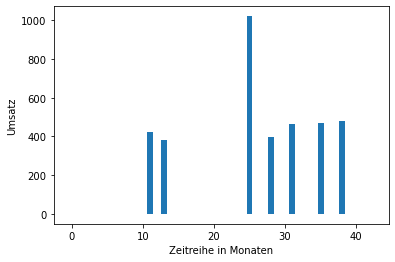

In [21]:
# Plotten der Umsätze eines Kunden "i"

i = 101

fig, ax = plt.subplots() # fig ist die ganze Grafik, ax ist die Oberfläche auf dem wir das Diagramm zeichnen können

# Die X-Achse stellt die Zeit dar:
timesteps = np.arange(len(X[0]))

ax.bar(timesteps, X[i].flatten())
ax.set_xlabel("Zeitreihe in Monaten")
ax.set_ylabel("Umsatz")
plt.show()

## Trennung in Training- und Test-Daten

70% Trainings- und 30% Testdaten.
Freunschaftsbeziehungen und der zeitliche Verlauf werden als Input voneinander getrennt.

In [22]:
X_time_train, X_time_test, X_friends_train, X_friends_test, y_train, y_test = train_test_split(
    X, friends, y, train_size=0.7, random_state=RANDOM_SEED
)

In [23]:
print(f'X_time_train: {X_time_train.shape}')
print(f'X_time_test: {X_time_test.shape}')
print(f'X_friends_train: {X_friends_train.shape}')
print(f'X_friends_test: {X_friends_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_time_train: (246, 43, 1)
X_time_test: (106, 43, 1)
X_friends_train: (246, 1)
X_friends_test: (106, 1)
y_train: (246, 1)
y_test: (106, 1)


## Das DL-Modell

**An dieser Stelle sind Sie gefragt..**
Das nachfolgende Codefragment enthält 4 modifizierbare Parameter, welche essenziell für die Genauigkeit des Netzwerks sind.
Diese sind so initialiert, dass das Netwerk ohne Veränderung eine schlechte Performance aufweist.
Ihre Aufgabe ist es nun diese Parameter so anzupassen, dass eine möglichst hohe Genauigkeit erzielt wird.

Die Parameter sind wie folgt beschrieben:
* **learning_rate**: Lernrate des Minimierungs-Algorithmus der Kostenfunktion (default: 0.00001, range: 0-∞)
* **lstm_cells**: Anzahl der Memory-Cells des Netzwerks. Besitzt ein Netzwerk mehr Zellen, kann es sich eine größere Anzahl an Merkmalen merken. Zu viele können zu *Overfitting* führen. (default: 1, range: 1-∞)
* **dropout**: Anteil der Merkmale, die zufällig gelöscht werden. Wirkt *Ovefitting* entgegen (default: 0.5, range: 0-1)
* **epochs**: Anzahl der Traingsdurchläufe (default: 10, range: 1-∞)

In [24]:
learning_rate = 0.01
lstm_cells = 5
dropout = 0.2
epochs = 25

Wir testen zunächst ein Modell, dass nur die Bestellverläufe kennt. Im zweiten Modell beziehen wir dann die sozialen Beziehungen mit ein.

In [25]:
model = Sequential()
model.add(Masking(mask_value=-1, input_shape=(X_time_train.shape[1],1)))
model.add(LSTM(lstm_cells, recurrent_dropout=dropout))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=['acc']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 43, 1)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 5)                 140       
_________________________________________________________________
dropout (Dropout)            (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


Die nachfolgende Code-Zelle enthält den Aufruf der *fit*-Methode, welche das Training des Netzes mit den oben angegebenen Parametern startet. Anschließend wird eine Zusammenfassung des Traingsverlaufs ausgegeben.

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
8/8 [==============================] - ETA: 0s - loss: 0.6868 - acc: 0.5813WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000207F56DD5E0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the fu

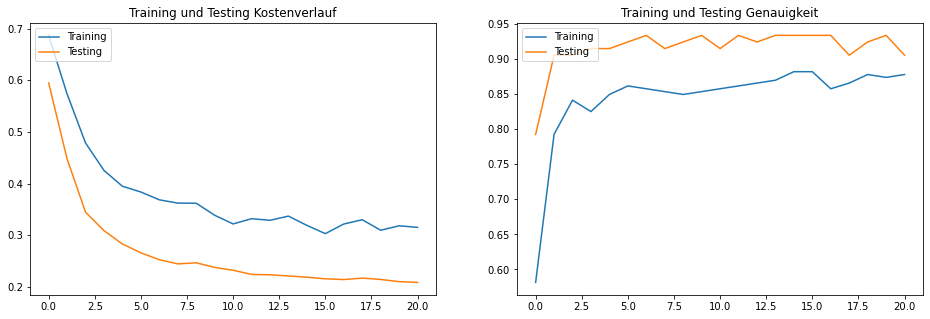

Genauigkeit: 93.40%
99 von 106 Beispielen richtig klassifiziert!


In [26]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, restore_best_weights=True, patience=5)
history = model.fit(x=X_time_train,y=y_train,epochs=epochs, verbose=1, callbacks=[es], validation_data=(X_time_test, y_test))
scores = model.evaluate(X_time_test, y_test, verbose=0)

plt.rcParams["figure.figsize"] = (16, 5)
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(history.history['loss'], label='Training')
ax1.plot(history.history['val_loss'], label='Testing')
ax1.legend(loc="upper left")
ax1.set_title("Training und Testing Kostenverlauf")
ax2.plot(history.history['acc'], label='Training')
ax2.plot(history.history['val_acc'], label='Testing')
ax2.legend(loc="upper left")#
ax2.set_title("Training und Testing Genauigkeit")
plt.show()

print("Genauigkeit: %.2f%%" % (scores[1]*100))
print(str(round(X_time_test.shape[0] * scores[1])) + " von " + str(X_time_test.shape[0]) + " Beispielen richtig klassifiziert!")

Nun das Model, dass die sozialen Daten kennt. Vergleichen Sie die Genauigkeit und den Trainingsverlauf.

In [27]:
input_time = Input(shape=(X_time_train.shape[1],1))
input_friends = Input(shape=(X_friends_train.shape[1]))

## Combined Model
x = Masking(mask_value=-1)(input_time)
x = LSTM(lstm_cells, recurrent_dropout=dropout)(x)
x = Dropout(dropout)(x)
x = concatenate([x, input_friends])

outputs = Dense(1, activation='sigmoid')(x)

model = Model(
    inputs=[input_time, input_friends],
    outputs=outputs,
    name="lstm_friendship_model",
)

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=['acc'],
)


Model: "lstm_friendship_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 43, 1)]      0                                            
__________________________________________________________________________________________________
masking_1 (Masking)             (None, 43, 1)        0           input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 5)            140         masking_1[0][0]                  
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 5)            0           lstm_1[0][0]                     
______________________________________________________________________________

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
7/8 [=========================>....] - ETA: 0s - loss: 0.4862 - acc: 0.7723WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000207FAF34820> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the fu

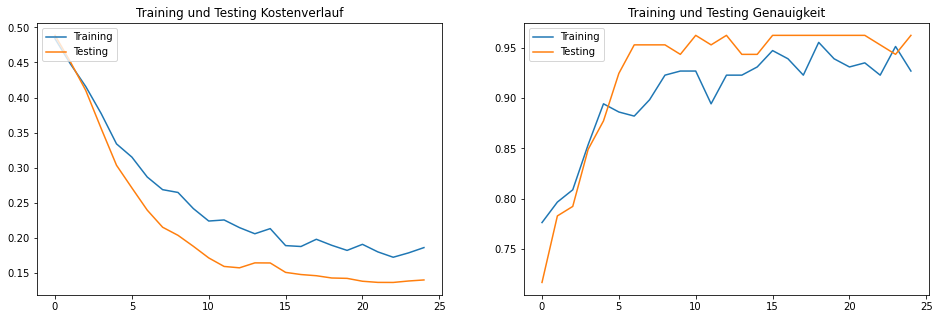

Genauigkeit: 96.23%
102 von 106 Beispielen richtig klassifiziert!


In [28]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, restore_best_weights=True, patience=5)
history = model.fit(x=[X_time_train, X_friends_train],y=y_train,epochs=epochs, verbose=1, callbacks=[es], validation_data=([X_time_test, X_friends_test], y_test))
scores = model.evaluate([X_time_test, X_friends_test], y_test, verbose=0)

plt.rcParams["figure.figsize"] = (16, 5)
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(history.history['loss'], label='Training')
ax1.plot(history.history['val_loss'], label='Testing')
ax1.legend(loc="upper left")
ax1.set_title("Training und Testing Kostenverlauf")
ax2.plot(history.history['acc'], label='Training')
ax2.plot(history.history['val_acc'], label='Testing')
ax2.legend(loc="upper left")#
ax2.set_title("Training und Testing Genauigkeit")
plt.show()

print("Genauigkeit: %.2f%%" % (scores[1]*100))
print(str(round(X_time_test.shape[0] * scores[1])) + " von " + str(X_time_test.shape[0]) + " Beispielen richtig klassifiziert!")